<a href="https://colab.research.google.com/github/clacri/iucr2020_compschool/blob/main/Databases_computing_school.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Accessing and querying databases with SQL Magic**

##**Load sql magic exension**

To communicate with SQL Databases from within a Google Colab notebook, we can use the SQL "magic" provided by the ipython-sql extension. Below, we'll use the load_ext magic to load the ipython-sql extension.

In [ ]:
%load_ext sql

##**Connecting to a Database**

Then establish a connection with the database.

To use a SQLite :memory: database, specify an empty URL.

In [ ]:
%sql sqlite://

'Connected: @None'

##**Load the data into the database**

To analyze the data using SQL, it first needs to be stored in the database. 

We will first read the dataset source .CSV into pandas dataframe. 

Then the PERSIST command in SQL magic simplifies the process of table creation and writing the data from a pandas dataframe into the table.

In [ ]:
import pandas
#%sql DROP TABLE pdb
pdb = pandas.read_csv('/content/drive/MyDrive/ColabNotebooks/Computing/Coiled-coils.csv')
%sql PERSIST pdb

 * sqlite://
Done.
 * sqlite://


'Persisted pdb'

You can verify that the table creation was successful by making a basic query like:

In [ ]:
%sql SELECT * FROM pdb limit 5;

 * sqlite://
Done.


index,PDB_id,Space_group,Resolution,Nres,Solvent_content,Anisotropic_Delta_B-factor,ASU_content,Architecture,Twin_fraction
0,1byz,P1,0.9,48,25.5,0.96,4C of 1H,Left-handed,0.0
1,3azd,P31,0.98,60,45.1,0.27,2C of 1H,Left-handed,0.0
2,1nkd,C2,1.09,59,40.6,6.88,1C of 2H,Left-handed,0.0
3,2ic6,P212121,1.15,147,41.5,6.86,2C of 2H,Left-handed,0.0
4,1p9i,C2221,1.17,29,32.7,3.5,1C of 1H,Left-handed,0.0


##**Data analysis**

###**Summary statistics**

Use the describe method to view the summary statistics of the data in the dataframe.

In [ ]:
pdb.describe(include='all')

,PDB_id,Space_group,Resolution,Nres,Solvent_content,Anisotropic_Delta_B-factor,ASU_content,Architecture,Twin_fraction
count,150,150,150.000000,150.000000,150.000000,150.000000,150,150,150.000000
unique,150,40,NaN,NaN,NaN,NaN,18,3,NaN
top,3ni0,C2,NaN,NaN,NaN,NaN,2C of 1H,Left-handed,NaN
freq,1,21,NaN,NaN,NaN,NaN,47,144,NaN
mean,NaN,NaN,2.149467,172.213333,55.019333,15.830400,NaN,NaN,0.029313
std,NaN,NaN,0.457604,120.150665,12.360598,15.311817,NaN,NaN,0.110580
min,NaN,NaN,0.900000,15.000000,25.500000,0.000000,NaN,NaN,0.000000
25%,NaN,NaN,1.900000,83.250000,46.050000,5.355000,NaN,NaN,0.000000
50%,NaN,NaN,2.115000,146.500000,53.450000,11.575000,NaN,NaN,0.000000
75%,NaN,NaN,2.500000,237.750000,63.725000,20.672500,NaN,NaN,0.000000


###**Architecture**

To know how many coiled-coil structures are left-handed, right-handed and partially right-handed we are going to query our database.

The SELECT statement with COUNT will retieve the number of rows that match the query criteria, and the WHERE clause can be added to the query to filter the result set.

In [ ]:
%sql select Count(*) from pdb where Architecture = "Left-handed"

 * sqlite://
Done.


Count(*)
144


You can use python variables in your SQL statements by adding a ":" prefix to your python variable names.

In [ ]:
architecture_right = "Right-handed"
%sql select Count(*) from pdb where Architecture = :architecture_right

 * sqlite://
Done.


Count(*)
2


In [ ]:
architecture_partially_right = "Partially right-handed"
%sql select Count(*) from pdb where Architecture = :architecture_partially_right

 * sqlite://
Done.


Count(*)
4


Alternatively, we can use the GROUP BY clause, that groups a result into subsets that has a matching values for one or more columns. Here architectures are grouped and then counted using the COUNT function.

For convenience, we can use %%sql (two %'s instead of one) at the top of a cell to indicate that we want the entire cell to be treated as SQL.

In [ ]:
%%sql
SELECT Architecture, count(*) from pdb group by Architecture

 * sqlite://
Done.


Architecture,count(*)
Left-handed,144
Partially right-handed,4
Right-handed,2


###**Space group distribution**

You can use the normal python assignment syntax to assign the results of your queries to python variables.

In [ ]:
space_group_distribution = %sql SELECT Space_group as "Space Group", count(*) as "Frequency" from pdb group by Space_group

 * sqlite://
Done.


You can convert a SQL query result to a pandas dataframe using the DataFrame() method.

Then we can easily graph our space group distribution after converting to a dataframe, using the barplot function provided by the Seaborn package.



''

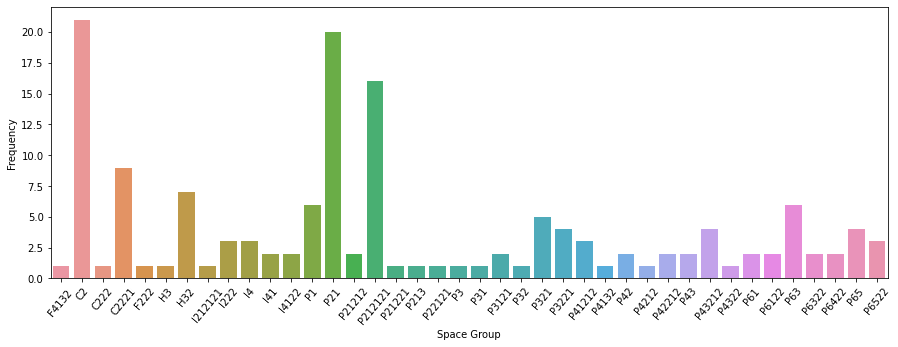

In [ ]:
dataframe = space_group_distribution.DataFrame()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))
plot = sns.barplot(x='Space Group',y='Frequency', data=dataframe)
plot.set_xticklabels(plot.get_xticklabels(), rotation=50)
;

###**Resolution vs Number of residues**

To create a scatter plot with the resolution on the x-axis and number of residues on the y-axis, we can use the joint plot function provided by the Seaborn package.

 * sqlite://
Done.


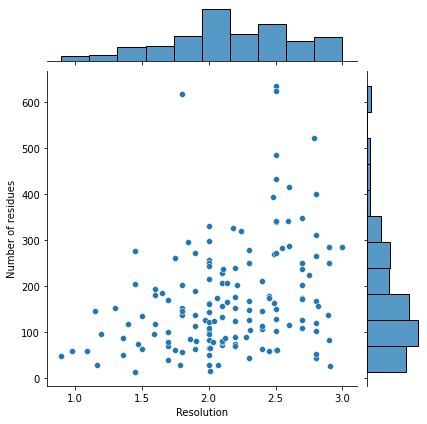

In [ ]:
Resolution_vs_Nres = %sql SELECT Resolution, Nres as "Number of residues" from pdb
dataframe = Resolution_vs_Nres.DataFrame()
plot = sns.jointplot(x='Resolution',y='Number of residues', data=dataframe)

###**Anisotropy**

The Anisotropic Delta B-factor measures the degree of anisotropy:
*   An anisotropic delta-B under 10 Å² indicates no anisotropy 
*   An anisotropic delta-B over 10 Å² indicates mild anisotropy 
*   An anisotropic delta-B over 25 Å² indicates strong anisotropy 
*   And an anisotropic delta-B over 50 Å² indicates severe anisotropy

To add a new column with these conditions we can use a function called np.select(). We’ll give it two arguments: a list of our conditions, and a corresponding list of the value we’d like to assign to each row in our new column.

In [ ]:
import numpy as np

# create a list of our conditions
conditions = [
    (pdb['Anisotropic_Delta_B-factor'] <= 10),
    (pdb['Anisotropic_Delta_B-factor'] > 10) & (pdb['Anisotropic_Delta_B-factor'] <= 25),
    (pdb['Anisotropic_Delta_B-factor'] > 25) & (pdb['Anisotropic_Delta_B-factor'] <= 50),
    (pdb['Anisotropic_Delta_B-factor'] > 50)
    ]

# create a list of the values we want to assign for each condition
values = ['No', 'Mild', 'Strong', 'Severe']

# create a new column and use np.select to assign values to it using our lists as arguments
pdb['Anisotropy'] = np.select(conditions, values)

# display updated DataFrame
pdb.head()

,PDB_id,Space_group,Resolution,Nres,Solvent_content,Anisotropic_Delta_B-factor,ASU_content,Architecture,Twin_fraction,Anisotropy
0,1byz,P1,0.90,48,25.5,0.96,4C of 1H,Left-handed,0.0,No
1,3azd,P31,0.98,60,45.1,0.27,2C of 1H,Left-handed,0.0,No
2,1nkd,C2,1.09,59,40.6,6.88,1C of 2H,Left-handed,0.0,No
3,2ic6,P212121,1.15,147,41.5,6.86,2C of 2H,Left-handed,0.0,No
4,1p9i,C2221,1.17,29,32.7,3.50,1C of 1H,Left-handed,0.0,No


Using the swarmplot method provided by the Seaborne package, we create a categorical scatter plot, then give as the input, category of Anisotropy on the x-axis and Anisotropic_Delta_B-factor on the y-axis.

''

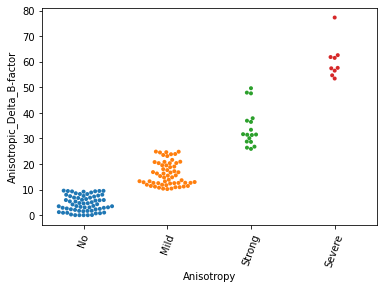

In [ ]:
plot = sns.swarmplot(x="Anisotropy", y="Anisotropic_Delta_B-factor", data=pdb, size=4)
plt.setp(plot.get_xticklabels(), rotation=70)
;

The describe method is used to understand the summary statistics associated with the values of Anisotropic_Delta_B-factor.

In [ ]:
pdb["Anisotropic_Delta_B-factor"].describe()

count    150.000000
mean      15.830400
std       15.311817
min        0.000000
25%        5.355000
50%       11.575000
75%       20.672500
max       77.260000
Name: Anisotropic_Delta_B-factor, dtype: float64

We use the idxmax method to compute the index values, at which the maximum value of Anisotropic_Delta_B-factor is obtained in the data frame.

In [ ]:
pdb["Anisotropic_Delta_B-factor"].idxmax()

137

We will use the .at method to find the PDB_id by passing the index 137 and the PDB_id column.

In [ ]:
pdb.at[137, "PDB_id"]

'2jee'

## **Exercises**

### **Query how many structures have Twinning**

In [ ]:
#@title Solution { display-mode: "form" }
%sql select Count(*) from pdb where Twin_fraction > 0

### **Barplot of the ASU content distribution**

In [ ]:
#@title Solution { display-mode: "form" }
ASU_content_distribution = %sql SELECT ASU_content as "ASU content", count(*) as "Frequency" from pdb group by ASU_content

dataframe = ASU_content_distribution.DataFrame()

plt.figure(figsize=(15, 5))
plot = sns.barplot(x='ASU content',y='Frequency', data=dataframe)
plot.set_xticklabels(plot.get_xticklabels(), rotation=50)
;

### **Scatterplot of Resolution vs Solvent Content**

In [ ]:
#@title Solution { display-mode: "form" }
Resolution_vs_Solvent = %sql SELECT Resolution, Solvent_content FROM pdb;

dataframe = Resolution_vs_Solvent.DataFrame()
plot = sns.jointplot(x='Resolution',y='Solvent_content', data=dataframe)